In [102]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score,\
                            confusion_matrix, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            classification_report

from sklearn.metrics import r2_score, \
                            mean_squared_error


from prettytable import PrettyTable

In [103]:
dataset = pd.read_csv('./dev.tsv', sep='\t', low_memory=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


In [104]:
dataset.describe()


,quality
count,120744.000000
mean,46.277852
std,11.924781
min,0.000000
25%,38.000000
50%,46.000000
75%,55.000000
max,100.000000


In [105]:
dataset.head(5)

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,NaN,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",NaN,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",NaN,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",NaN,Alentejano,NaN,NaN,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,NaN,Coda di Volpe,Sorrentino,37.0


In [106]:
dataset.isna().sum()

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

In [107]:
mask = dataset.country.isna()
len(mask)

120744

In [108]:
dataset[mask]

,country,description,designation,province,region_1,region_2,variety,winery,quality
28353,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,NaN,NaN,NaN,Pinot Noir,Chilcas,37.0
48154,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,NaN,NaN,NaN,Pinot Noir,Chilcas,37.0
76257,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,NaN,NaN,NaN,Pinot Noir,Chilcas,37.0
88206,NaN,Delicate white flowers and a spin of lemon pee...,Askitikos,NaN,NaN,NaN,Assyrtiko,Tsililis,38.0
92096,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,NaN,NaN,NaN,Red Blend,Büyülübağ,49.0


In [109]:
piedra = dataset[dataset.winery == 'Chilcas']
Tsililis = dataset[dataset.winery == 'Tsililis']
buyulu = dataset[dataset.winery == 'Büyülübağ']

In [110]:
print(piedra.country.nunique())
print(Tsililis.country.nunique())
print(buyulu.country.nunique())

1
1
0


In [111]:
dataset.nunique()

country           48
description    85005
designation    27800
province         444
region_1        1206
region_2          18
variety          603
winery         14105
quality           86
dtype: int64

In [112]:
dataset.isna().sum()

country            5
description        0
designation    36518
province           5
region_1       20008
region_2       72008
variety            0
winery             0
quality            0
dtype: int64

In [113]:
dataset.__len__()

120744

In [114]:
sns.set_theme(style="ticks")


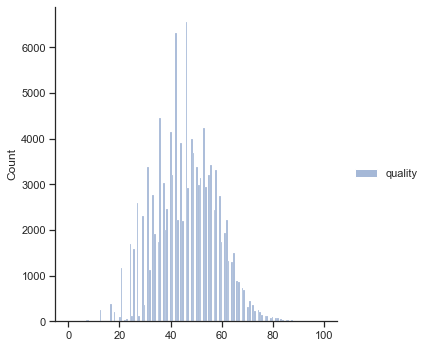

In [115]:
sns.displot(data= dataset)

In [116]:
ds = dataset[['country', 'region_1', 'region_2', 'province']]

In [117]:
count_nan = ds.isna().sum(axis=1)
# (df[df["number_of_reviews"]==0].index == df[df["last_review"].isna()].index).all()

In [118]:
print(Counter(count_nan))

Counter({1: 52000, 0: 48736, 2: 20003, 4: 5})


In [119]:
ind = dataset[count_nan == 4].index
ind

Int64Index([28353, 48154, 76257, 88206, 92096], dtype='int64')

In [120]:
dataset = dataset.drop(dataset.index[ind])

In [121]:
print(dataset.isna().sum())
print(dataset.__len__())



country            0
description        0
designation    36518
province           0
region_1       20003
region_2       72003
variety            0
winery             0
quality            0
dtype: int64
120739


since region_2 has most of its data null/non present we decide to drop this column

In [122]:
dataset = dataset.drop(columns=['region_2'])
dataset.isna().sum()

country            0
description        0
designation    36518
province           0
region_1       20003
variety            0
winery             0
quality            0
dtype: int64

removing designation and region_1 as well, keeping them for possible use later




In [124]:
later_use = dataset[['designation', 'region_1']]
dataset.drop(columns=['designation', 'region_1'] ,inplace=True)

In [125]:
print(dataset.info())
print(dataset.isna().sum())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 120739 entries, 0 to 120743
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120739 non-null  object 
 2   province     120739 non-null  object 
 3   variety      120739 non-null  object 
 4   winery       120739 non-null  object 
 5   quality      120739 non-null  float64
dtypes: float64(1), object(5)
memory usage: 6.4+ MB
None
country        0
description    0
province       0
variety        0
winery         0
quality        0
dtype: int64


# Preprocessing Categorical Data


In [136]:
val_count = []
for col in dataset.columns:
    if col == 'description':
        continue
    val_count.append(dict(Counter(dataset[col])))

val_count

[{'France': 16835,
  'US': 49908,
  'Portugal': 4228,
  'Italy': 18848,
  'New Zealand': 2646,
  'Argentina': 4519,
  'Chile': 4647,
  'Austria': 2447,
  'South Africa': 1796,
  'Australia': 3949,
  'Germany': 1963,
  'Spain': 6657,
  'Greece': 711,
  'Canada': 153,
  'Croatia': 72,
  'Moldova': 51,
  'Israel': 499,
  'Turkey': 39,
  'Egypt': 3,
  'Slovakia': 3,
  'Hungary': 187,
  'Serbia': 10,
  'Mexico': 47,
  'Romania': 115,
  'Bulgaria': 63,
  'Georgia': 36,
  'Slovenia': 71,
  'Morocco': 10,
  'Lithuania': 5,
  'Lebanon': 31,
  'Macedonia': 14,
  'Brazil': 21,
  'Cyprus': 25,
  'Czech Republic': 6,
  'Luxembourg': 7,
  'Uruguay': 81,
  'Ukraine': 4,
  'Japan': 2,
  'India': 5,
  'US-France': 1,
  'England': 7,
  'China': 3,
  'South Korea': 4,
  'Tunisia': 1,
  'Bosnia and Herzegovina': 3,
  'Switzerland': 3,
  'Montenegro': 2,
  'Albania': 1},
 {'Alsace': 1357,
  'California': 35572,
  'Oregon': 3661,
  'Alentejano': 694,
  'Southern Italy': 1183,
  'Marlborough': 1304,
  'Tusca

In [139]:
countries = dataset['country'].value_counts()
countries

US                        49908
Italy                     18848
France                    16835
Spain                      6657
Chile                      4647
Argentina                  4519
Portugal                   4228
Australia                  3949
New Zealand                2646
Austria                    2447
Germany                    1963
South Africa               1796
Greece                      711
Israel                      499
Hungary                     187
Canada                      153
Romania                     115
Uruguay                      81
Croatia                      72
Slovenia                     71
Bulgaria                     63
Moldova                      51
Mexico                       47
Turkey                       39
Georgia                      36
Lebanon                      31
Cyprus                       25
Brazil                       21
Macedonia                    14
Serbia                       10
Morocco                      10
England 